In [1]:
from keras.models import load_model, model_from_json
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda, GlobalAveragePooling2D, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
import keras.backend as K
%matplotlib inline

Using TensorFlow backend.


In [2]:
classifier = load_model('VGG16-finetuned_last3-27-0.70.hdf5')

In [13]:
model_json = classifier.to_json()
with open("test.json", "w") as json_file:
    json_file.write(model_json)

In [6]:
classifier.save_weights('test.hdf5')

In [3]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [2]:
img_input = Input(shape=(224, 224, 3), name='input_3')
# Block 1
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

# Block 4
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

# Block 5
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
feat_map = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(feat_map)

# Classifier
x = GlobalAveragePooling2D(name='global_average_pooling2d_2')(x)
x = Dense(256, activation='relu', name='dense_3')(x)

x = Dropout(0.5, name='dropout_2')(x)

# and a logistic layer -- let's say we have 200 classes
predictions = Dense(20, activation='softmax', name='dense_4')(x)

x  = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu', name='bbox_conv1')(feat_map)
x = BatchNormalization(name='bbox_bn_1')(x)
x = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu', name='bbox_conv2')(x)
x = BatchNormalization(name='bbox_bn_2')(x)
x = Flatten(name='bbox_flatten')(x)
bbox = Dense(4, name='bbox')(x)

test = Model(inputs=img_input, outputs=bbox)

In [3]:
test.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [4]:
test.load_weights('test.hdf5', by_name=True)

In [5]:
for num, layer in enumerate(test.layers):
    print(num, layer.name)

0 input_3
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 bbox_conv1
19 bbox_bn_1
20 bbox_conv2
21 bbox_bn_2
22 bbox_flatten
23 bbox


In [6]:
for layer in test.layers[:18]:
    layer.trainable = False
for layer in test.layers[18:]:
    layer.trainable = True

In [7]:
test.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [8]:
from skimage.io import imread
from skimage.transform import resize

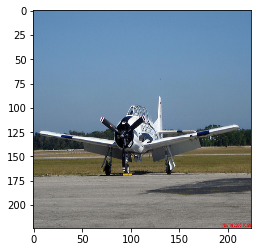

In [9]:
test_im = imread('bbox_dataset/images/2008_000021.jpg')
test_im = resize(test_im, (224, 224), mode='reflect')
plt.imshow(test_im)

In [10]:
import numpy as np

In [11]:
test_im = np.expand_dims(test_im, 0)
test_im.shape

(1, 224, 224, 3)

In [12]:
preds = test.predict(test_im)

In [13]:
preds.shape

(1, 4)

In [24]:
labels = np.zeros(preds[0].shape)
labels[preds[0]>0.5] = 1
np.argmax(labels, axis=-1)

array([0], dtype=int64)

In [23]:
preds[1].shape

(1, 4)

In [14]:
import os
import numpy as np
import xml.etree.ElementTree as etree
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
img_path = './bbox_dataset/images/'
annot_path = './bbox_dataset/annotations/'

In [16]:
import pickle

In [17]:
with open('final_parition.pkl', 'rb') as part_file:
    final_parition = pickle.load(part_file)

with open('labels_bbox_only.pkl', 'rb') as bboxes_only:
    labels_bbox_only = pickle.load(bboxes_only)

In [18]:
import numpy as np
from skimage.io import imread
from skimage.transform import resize

class DataGenerator(object):

    def __init__(self, dim_x = 224, dim_y = 224, channels = 3, batch_size = 32, shuffle = True):
        'Initialization'
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.dim_z = channels
        self.batch_size = batch_size
        self.shuffle = shuffle

    def generate(self, labels, list_IDs):
        'Generates batches of samples'
        # Infinite loop
        while 1:
        # Generate order of exploration of dataset
            indexes = self.__get_exploration_order(list_IDs)

            # Generate batches
            imax = int(len(indexes)/self.batch_size)
            for i in range(imax):
            # Find list of IDs
                list_IDs_temp = [list_IDs[k] for k in indexes[i*self.batch_size:(i+1)*self.batch_size]]

                # Generate data
                X, y = self.__data_generation(labels, list_IDs_temp)

                yield X, y

    def __get_exploration_order(self, list_IDs):
        'Generates order of exploration'
        # Find exploration order
        indexes = np.arange(len(list_IDs))
        if self.shuffle == True:
            np.random.shuffle(indexes)
        return indexes

    def __data_generation(self, labels, list_IDs_temp):
        'Generates data of batch_size samples' # X : (n_samples, v_size, v_size, v_size, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.dim_x, self.dim_y, self.dim_z))
        y = np.empty((self.batch_size, 4), dtype = int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            
            img = imread('./bbox_dataset/images/'+ID+'.jpg')
            img = resize(img, (self.dim_x, self.dim_y), mode='reflect')
            
            X[i] = img

            # Store volume
            #X[i, :, :, :, 0] = np.load(ID + '.npy')

            # Store class
            y[i] = labels[ID]

        return X, y


In [19]:
params = {'dim_x': 224,
          'dim_y': 224,
          'channels': 3,
          'batch_size': 8,
          'shuffle': False}

# Datasets
partition = final_parition # IDs
labels = labels_bbox_only # Labels

# Generators
training_generator = DataGenerator(**params).generate(labels, partition['train'])
validation_generator = DataGenerator(**params).generate(labels, partition['valid'])

In [20]:
test.compile(optimizer=SGD(lr=0.0001, momentum=0.9),loss='mean_squared_error',metrics=['accuracy'])

In [21]:
filepath="bboxes-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [22]:
len(final_parition['train']), len(final_parition['valid'])

(3093, 89)

In [23]:
test.fit_generator(training_generator, 3093 // 8, epochs=30 ,validation_data=validation_generator, validation_steps=89//8,
           callbacks=callbacks_list)

Epoch 1/30
386/386 [==============================] - 248s 643ms/step - loss: 6488.2110 - acc: 0.7001 - val_loss: 14158.4604 - val_acc: 0.4545
Epoch 2/30
386/386 [==============================] - 245s 634ms/step - loss: 4897.4239 - acc: 0.7141 - val_loss: 12662.6726 - val_acc: 0.4545
Epoch 3/30
386/386 [==============================] - 245s 635ms/step - loss: 4433.2717 - acc: 0.7322 - val_loss: 8176.6460 - val_acc: 0.5682
Epoch 4/30
386/386 [==============================] - 245s 635ms/step - loss: 4021.7735 - acc: 0.7584 - val_loss: 7419.4239 - val_acc: 0.5227
Epoch 5/30
386/386 [==============================] - 245s 635ms/step - loss: 3753.0223 - acc: 0.7775 - val_loss: 7121.1009 - val_acc: 0.5568
Epoch 6/30
386/386 [==============================] - 245s 635ms/step - loss: 3766.9041 - acc: 0.7834 - val_loss: 7687.9059 - val_acc: 0.6477
Epoch 7/30
386/386 [==============================] - 245s 634ms/step - loss: 3828.9018 - acc: 0.7934 - val_loss: 9841.0675 - val_acc: 0.6591
Epoc

In [24]:
import cv2

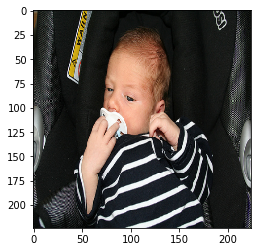

In [53]:
test_img = imread('./bbox_dataset/images/2008_000213.jpg')
test_img = resize(test_img, (224, 224), mode='reflect')
plt.imshow(test_img)

In [59]:
gt_box = labels['2008_000213']
gt_box

(95, 24, 414, 333)

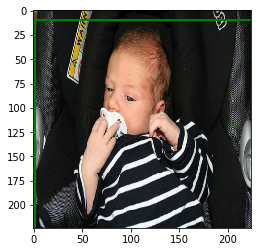

In [55]:
import matplotlib.patches as patches

coords = (gt_box[0], gt_box[1]), gt_box[2]-gt_box[0]+1, gt_box[3]-gt_box[1]+1
plt.imshow(test_img)
plt.gca().add_patch(plt.Rectangle(*coords, fill=False, edgecolor='g', linewidth=2))

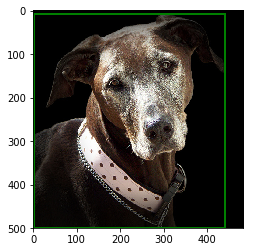

In [35]:
test_img = imread('./bbox_dataset/images/2008_000213.jpg')
coords = (gt_box[0], gt_box[1]), gt_box[2]-gt_box[0]+1, gt_box[3]-gt_box[1]+1
plt.imshow(test_img)
plt.gca().add_patch(plt.Rectangle(*coords, fill=False, edgecolor='g', linewidth=2))

In [56]:
test_img = np.expand_dims(test_img, 0)
bbox = test.predict(test_img)
bbox

array([[  39.48564911,   60.78292465,  365.85916138,  306.67687988]], dtype=float32)

In [57]:
tbox = np.round(bbox[0])
tbox = bbox.astype(int)
tbox

array([[ 39,  60, 365, 306]])

In [49]:
test_img[0].shape

(224, 224, 3)

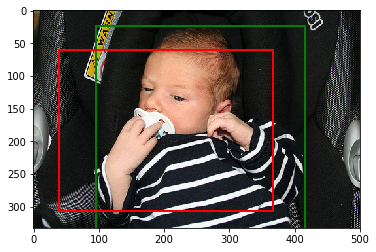

In [61]:
test_img = imread('./bbox_dataset/images/2008_000213.jpg')
xmin, ymin, xmax, ymax = tbox[0][0], tbox[0][1], tbox[0][2], tbox[0][3]
gt_xmin, gt_ymin, gt_xmax, gt_ymax = gt_box[0], gt_box[1], gt_box[2], gt_box[3]
coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
coords_gt = (gt_xmin, gt_ymin), gt_xmax - gt_xmin + 1, gt_ymax - gt_ymin + 1
plt.imshow(test_img)
plt.gca().add_patch(plt.Rectangle(*coords_gt, fill=False, edgecolor='g', linewidth=2))
plt.gca().add_patch(plt.Rectangle(*coords, fill=False, edgecolor='r', linewidth=2))

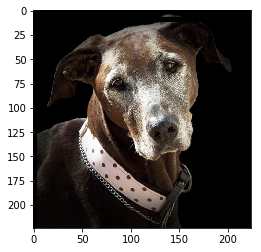

In [28]:
plt.imshow(img)